In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import ModelCheckpoint


In [2]:
!pip install kaggle

In [3]:
!kaggle datasets download -d kingburrito666/shakespeare-plays

Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 10, in <module>
    sys.exit(main())
             ^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/kaggle/cli.py", line 68, in main
    out = args.func(**command_args)
          ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/kaggle/api/kaggle_api_extended.py", line 1734, in dataset_download_cli
    with self.build_kaggle_client() as kaggle:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/kaggle/api/kaggle_api_extended.py", line 688, in build_kaggle_client
    username=self.config_values['username'],
             ~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^
KeyError: 'username'


In [4]:
import kagglehub
import os
import numpy as np
import shutil
import pandas as pd

# Download the dataset
shakespeare_dataset_path = kagglehub.dataset_download("kingburrito666/shakespeare-plays")
print(' dataset import complete.')

100%|██████████| 4.55M/4.55M [00:00<00:00, 127MB/s]

Extracting files...


 dataset import complete.


# **2. Load and Inspect Dataset**

In [5]:
import os

# Build the correct file path
data_path = os.path.join(shakespeare_dataset_path, 'alllines.txt')

# Load the text data
with open(data_path, 'r', encoding='utf-8') as f:
    text = f.read()

# Print some basic info
print(f"Text length: {len(text)} characters")
print(text[:500])  # preview the first 500 characters


Text length: 4583798 characters
"ACT I"
"SCENE I. London. The palace."
"Enter KING HENRY, LORD JOHN OF LANCASTER, the EARL of WESTMORELAND, SIR WALTER BLUNT, and others"
"So shaken as we are, so wan with care,"
"Find we a time for frighted peace to pant,"
"And breathe short-winded accents of new broils"
"To be commenced in strands afar remote."
"No more the thirsty entrance of this soil"
"Shall daub her lips with her own children's blood,"
"Nor more shall trenching war channel her fields,"
"Nor bruise her flowerets with the ar


# **3. Character Mapping & Encoding**

In [6]:
# Unique characters
chars = sorted(set(text))
char2idx = {u: i for i, u in enumerate(chars)}
idx2char = np.array(chars)

# Encode text to integers
text_as_int = np.array([char2idx[c] for c in text])


# **4. Create Sequences for Training**

In [7]:
# Hyperparameters
sequence_length = 100
batch_size = 64
buffer_size = 10000

char_dataset = tf.data.Dataset.from_tensor_slices(text_as_int)
sequences = char_dataset.batch(sequence_length + 1, drop_remainder=True)

def split_input_target(chunk):
    return chunk[:-1], chunk[1:]

dataset = sequences.map(split_input_target)
dataset = dataset.shuffle(buffer_size).batch(batch_size, drop_remainder=True)

# Validation split
val_size = int(0.1 * len(dataset))
val_dataset = dataset.take(val_size)
train_dataset = dataset.skip(val_size)


# **5. Build LSTM Model**

In [8]:
# Model Hyperparameters
embedding_dim = 256
rnn_units = 1024
dropout = 0.2

def build_model(vocab_size, embedding_dim, rnn_units, batch_size):
    model = tf.keras.Sequential([
        layers.Input(batch_shape=(batch_size, None)),
        layers.Embedding(vocab_size, embedding_dim),
        layers.LSTM(rnn_units, return_sequences=True, stateful=True, dropout=dropout),
        layers.Dense(vocab_size)
    ])
    return model

vocab_size = len(chars)
model = build_model(vocab_size, embedding_dim, rnn_units, batch_size)


# **6. Compile and Train**

In [ ]:
learning_rate = 0.001

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

checkpoint_path = './shakespeare_model.h5'
checkpoint_cb = ModelCheckpoint(filepath=checkpoint_path, save_best_only=True)

history = model.fit(train_dataset, validation_data=val_dataset, epochs=15, callbacks=[checkpoint_cb])


Epoch 1/15
 21/639 ━━━━━━━━━━━━━━━━━━━━ 1:22:50 8s/step - accuracy: 0.0923 - loss: 4.0038

# **7. Plot Loss and Accuracy**

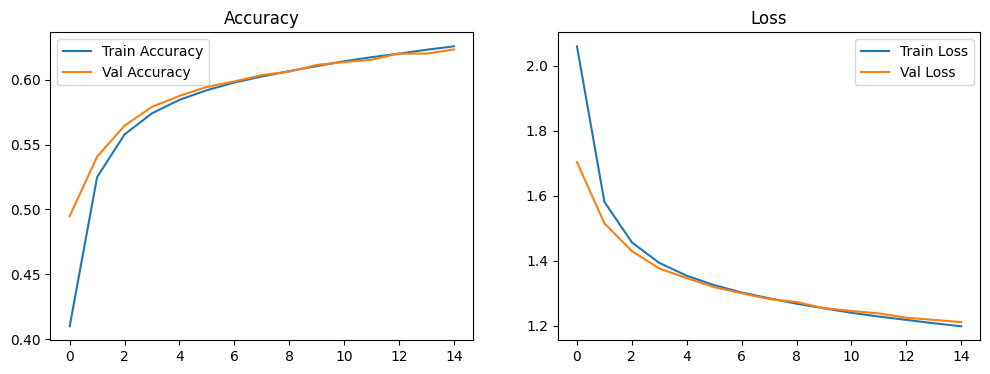

In [10]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss')

plt.show()


# **8. Generate Text**

In [24]:
def generate_text(model, start_string, temperature=1.0, num_generate=1000):
    # Convert start string to numbers (vectorize)
    input_eval = [char2idx[s] for s in start_string]
    input_eval = tf.expand_dims(input_eval, 0)

    # Empty list to store results
    text_generated = []

    # Reset states for RNN layers only
    for layer in model.layers:
        if hasattr(layer, 'reset_states'):
            layer.reset_states()

    for _ in range(num_generate):
        predictions = model(input_eval)
        predictions = predictions[:, -1, :] / temperature
        predicted_id = tf.random.categorical(predictions, num_samples=1)[-1, 0].numpy()

        # Feed the prediction back into the model
        input_eval = tf.expand_dims([predicted_id], 0)
        text_generated.append(idx2char[predicted_id])

    return start_string + ''.join(text_generated)


# **BLEU Score Evaluation**

In [34]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

generated = generate_text(model, start_string="To be", temperature=0.8, num_generate=200)
reference = text[text.find("To be"):text.find("To be")+200]

smoothie = SmoothingFunction().method4
score = sentence_bleu([list(reference)], list(generated), smoothing_function=smoothie)
print("BLEU score:", score)


BLEU score: 0.3101686256746156
